In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder
from scipy import stats
from scipy.stats import norm,skew
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer,log_loss

In [87]:
df=pd.read_csv("train.csv", parse_dates=['timestamp'])
df_macro=pd.read_csv("macro.csv", parse_dates=['timestamp'])
df = pd.merge(df,df_macro, how='left', on='timestamp')

In [88]:
#df.plot.scatter(x='full_sq',y='price_doc',xlim=(0,1000),ylim=(0,100000000))
print df.shape

(30471, 391)


In [4]:
#df2=pd.read_csv("train.csv", parse_dates=['timestamp'])

In [89]:
df = df.drop(df[df['full_sq']>5000].index)

In [90]:
df = df.drop(df[df['price_doc']>80000000].index)

In [91]:
df = df.drop(df[df['life_sq']>4000].index)
df = df.drop(df[df['full_sq']==0].index)
df = df.drop(df[df['life_sq']==0].index)
#df.plot.scatter(x='life_sq',y='price_doc',xlim=(0,1000),ylim=(0,100000000))
#plt.show()

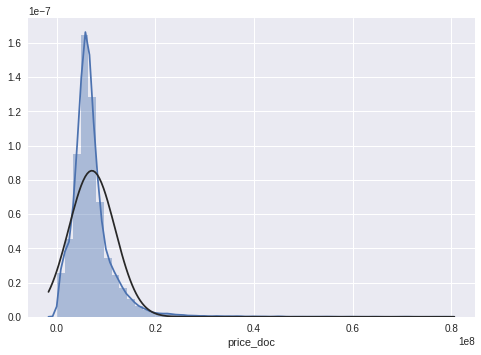

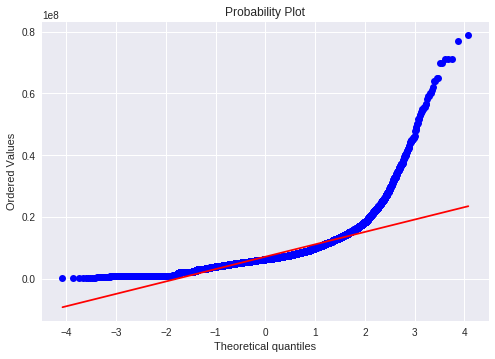

In [8]:
#df['price_doc'] = np.log(df['price_doc'])
sns.distplot(df['price_doc'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['price_doc'], plot=plt)
plt.show()

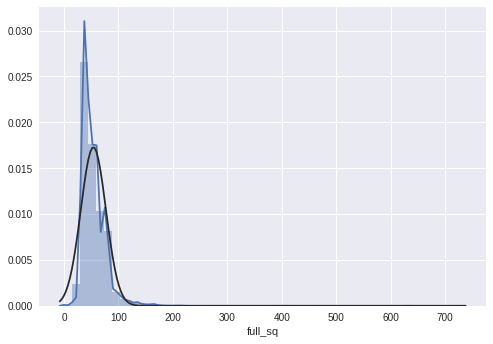

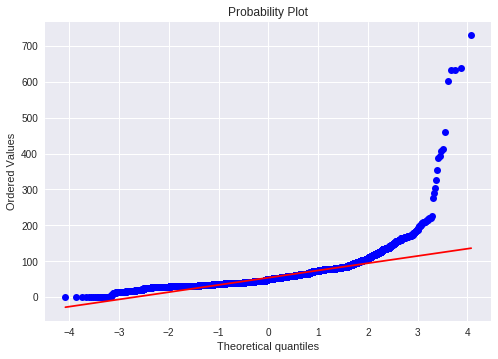

In [9]:
#df['full_sq'] = np.log(df['full_sq'])
sns.distplot(df['full_sq'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['full_sq'], plot=plt)
plt.show()

In [10]:

sns.distplot(train_num['life_sq'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['life_sq'], plot=plt)
plt.show()

NameError: name 'train_num' is not defined

In [15]:
df = pd.merge(df,df_macro, how='left', on='timestamp')

In [103]:
df["yearmonth"] = df["timestamp"].dt.year*100 + df["timestamp"].dt.month

In [104]:
df = df.drop(df[df['yearmonth']>201506].index)

In [105]:
df = df.drop(df[df['state']>4].index)
df =df.drop(df[df['build_year']>2020].index)

In [106]:
numerical_features = df.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("price_doc")
numerical_features = numerical_features.drop("timestamp")

In [107]:
train_num = df[numerical_features]

In [108]:
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 192859
Remaining NAs for numerical features in train : 0


In [281]:
categorical_features=df.select_dtypes(include=["object"]).columns
#categorical_features = categorical_features.drop("price_doc")
#categorical_features = categorical_features.drop("timestamp")
train_cat=df[categorical_features]

In [110]:
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

276 skewed numerical features to log transform


In [282]:
train_num.shape
train_cat.shape

(30417, 15)

In [283]:
print("NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
train_cat = pd.get_dummies(train_cat)
print("Remaining NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
print train_cat.shape

NAs for categorical features in train : 0
Remaining NAs for categorical features in train : 0
(30417, 177)


In [112]:
df.price_doc=np.log(df.price_doc)
y=df.price_doc

In [113]:
train=pd.concat([train_num,train_cat],axis=1)


In [114]:
x_train,x_test,y_train,y_test=train_test_split(train,y,test_size=0.3,random_state=1)
stdscale=StandardScaler()
x_train.loc[:,numerical_features]=stdscale.fit_transform(x_train.loc[:,numerical_features])
x_test.loc[:,numerical_features]=stdscale.fit_transform(x_test.loc[:,numerical_features])

In [115]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, x_test, y_test, scoring = scorer, cv = 10))
    return(rmse)
#print y,df2.price_doc

0        15.581952
1        15.607270
2        15.555977
3        16.388123
4        16.608603
5        16.023785
6        15.520259
7        14.508658
8        15.483217
9        14.508658
10       15.352378
11       15.384126
12       15.444751
13       15.464169
14       15.424948
15       14.430696
16       15.656060
17       15.590463
18       15.882373
19       15.464169
20       15.919645
21       15.464169
22       15.648092
23       15.564710
24       15.607270
25       13.864301
26       15.424948
27       15.363073
28       15.926257
29       15.590463
           ...    
30441    17.035957
30442    15.285686
30443    15.839363
30444    16.252535
30445    16.131936
30446    15.627955
30447    15.667632
30448    15.745312
30449    16.037716
30450    16.350001
30451    14.688601
30452    15.732433
30453    15.218352
30454    15.656060
30455    16.014397
30456    13.815511
30457    15.869634
30458    15.667232
30459    15.569723
30460    16.066802
30461    15.424948
30462    16.

In [62]:
clf=LinearRegression()
clf.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [63]:
print("RMSE on Training set :", rmse_cv_train(clf).mean())
print("RMSE on Test set :", rmse_cv_test(clf).mean())
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)


('RMSE on Training set :', 115013183.14153954)
('RMSE on Test set :', 0.4843616275663794)


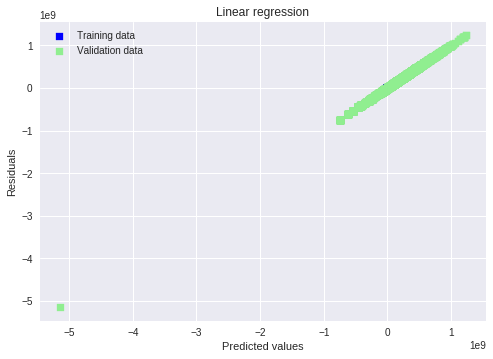

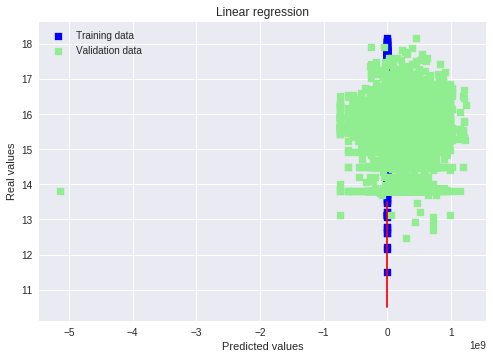

In [64]:
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

('Best alpha :', 30.0)
Try again for more precision with alphas centered around 30.0
('Best alpha :', 42.0)
('Ridge RMSE on Training set :', 0.47622793063012542)
('Ridge RMSE on Test set :', 0.47974463609020912)


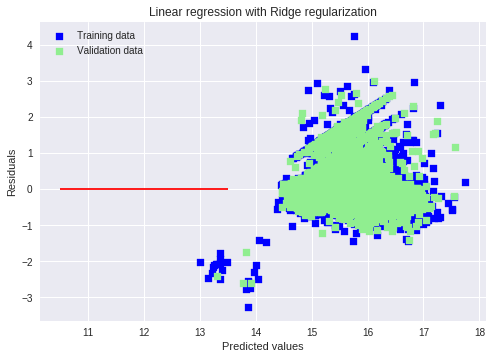

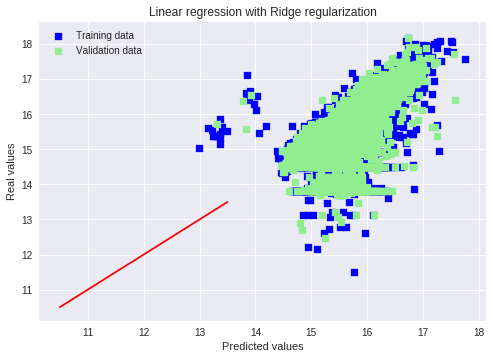

Ridge picked 557 features and eliminated the other 2 features


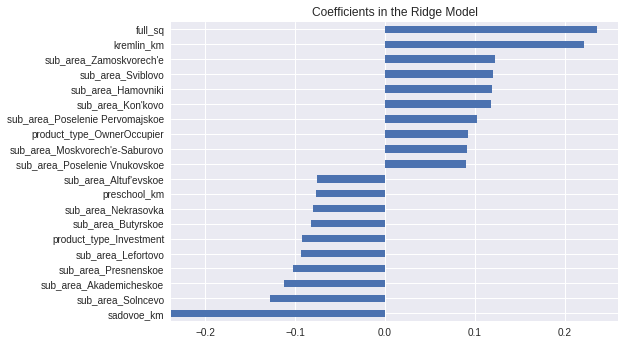

In [72]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(x_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(x_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(x_train)
y_test_rdg = ridge.predict(x_test)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = x_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

('Best alpha :', 0.00029999999999999997)
Try again for more precision with alphas centered around 0.0003
('Best alpha :', 0.00020999999999999998)
('Lasso RMSE on Training set :', 0.47611382827562931)
('Lasso RMSE on Test set :', 0.47795590844138064)


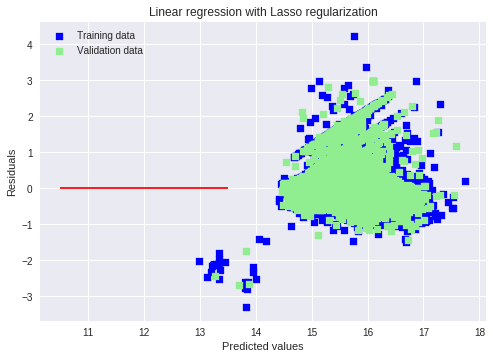

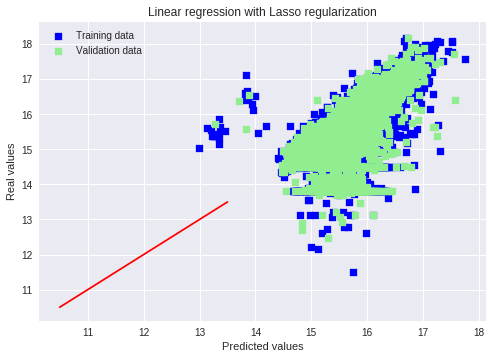

Lasso picked 283 features and eliminated the other 198 features


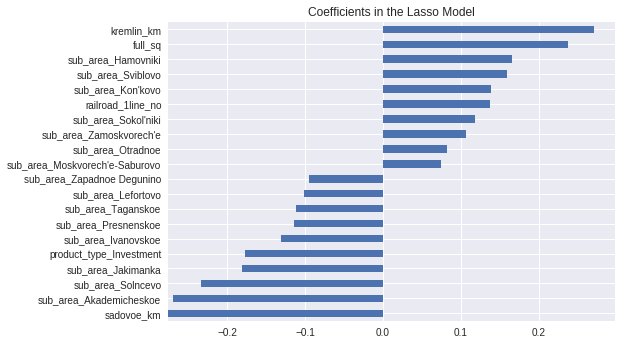

In [116]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(x_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(x_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(x_train)
y_test_las = lasso.predict(x_test)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = x_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,water_1line_yes,big_road1_1line_no,big_road1_1line_yes,railroad_1line_no,railroad_1line_yes,ecology_excellent,ecology_good,ecology_no data,ecology_poor,ecology_satisfactory
25648,1.172982,0.730353,0.668292,-1.960412,0.407297,-0.480032,0.165891,1.411346,0.794801,-0.09059,...,0,1,0,1,0,0,0,0,1,0
14759,-0.064422,-1.243320,-0.650398,0.529643,-0.267952,2.567210,0.161695,-1.497442,0.040000,-0.09059,...,0,1,0,1,0,1,0,0,0,0
16976,0.187514,-0.571215,-0.741937,-0.888004,0.407297,-0.480032,0.175875,-1.497442,0.639120,-0.09059,...,0,1,0,1,0,0,0,0,0,1
29815,1.646512,1.081621,0.757750,1.050219,0.710930,-0.480032,0.171730,1.411346,0.935633,-0.09059,...,0,1,0,1,0,0,0,0,0,1
14750,-0.065445,-0.924465,-0.741937,-0.260685,-0.267952,-0.480032,0.166309,-1.497442,0.267775,-0.09059,...,0,1,0,1,0,1,0,0,0,0


In [153]:
df_test=pd.read_csv("test.csv", parse_dates=['timestamp'])

In [154]:
df_test=pd.merge(df_test,df_macro, how='left', on='timestamp')

In [155]:
df_test["yearmonth"] = df_test["timestamp"].dt.year*100 + df_test["timestamp"].dt.month

In [160]:
numerical_features2= df_test.select_dtypes(exclude = ["object"]).columns
#numerical_features2= numerical_features2.drop("price_doc")
numerical_features2= numerical_features2.drop("timestamp")
print df_test.shape
print df.shape

(7662, 320)
(30417, 321)


In [161]:
test_num = df_test[numerical_features2]
print test_num.shape

(7662, 304)


In [162]:
print("NAs for numerical features in test : " + str(test_num.isnull().values.sum()))
test_num = test_num.fillna(test_num.median())
print("Remaining NAs for numerical features in test : " + str(test_num.isnull().values.sum()))

NAs for numerical features in test : 31019
Remaining NAs for numerical features in test : 0


In [65]:
#test_num.life_sq.fillna(test_num.life_sq.median())

In [98]:
#int test_num

In [163]:
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print missing_data.head()
print df_test.shape
print df.shape

                                      Total   Percent
cafe_avg_price_1000                    1222  0.159488
cafe_sum_1000_max_price_avg            1222  0.159488
cafe_sum_1000_min_price_avg            1222  0.159488
build_count_mix                        1218  0.158966
raion_build_count_with_material_info   1218  0.158966
(7662, 320)
(30417, 321)


In [164]:
#df=df.drop((missing_data[missing_data['Percent']>0.2]).index,1)
df_test = df_test.drop((missing_data[missing_data['Percent'] > 0.2]).index,1)

In [199]:
print train.shape
print df_test.shape

(30417, 481)
(7662, 320)


In [166]:
numerical_features2= df_test.select_dtypes(exclude = ["object"]).columns
#numerical_features2= numerical_features2.drop("price_doc")
numerical_features2= numerical_features2.drop("timestamp")
test_num = df_test[numerical_features2]
print("NAs for numerical features in test : " + str(test_num.isnull().values.sum()))
test_num = test_num.fillna(test_num.median())
print("Remaining NAs for numerical features in test : " + str(test_num.isnull().values.sum()))
print test_num.shape

NAs for numerical features in test : 31019
Remaining NAs for numerical features in test : 0
(7662, 304)


In [288]:
#categorical_features2=df_test.select_dtypes(include=["object"]).columns
test_cat=df_test[categorical_features]
print test_cat.shape

(7662, 15)


In [168]:
skewed_features = skewness.index
test_num[skewed_features] = np.log1p(test_num[skewed_features])
test_num.shape

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log1p
  from ipykernel import kernelapp as app


(7662, 304)

In [290]:
print("NAs for categorical features in test : " + str(test_cat.isnull().values.sum()))
test_cat = pd.get_dummies(test_cat)
print("Remaining NAs for categorical features in test : " + str(test_cat.isnull().values.sum()))
test_cat.shape
test_cat['sub_area_Poselenie Klenovskoe']=0

NAs for categorical features in test : 0
Remaining NAs for categorical features in test : 0


In [291]:
test=pd.concat([test_num,test_cat],axis=1)
print test.shape

(7662, 481)


In [297]:
test2=test.fillna(method='ffill')

In [298]:
test2.loc[:,numerical_features2]=stdscale.fit_transform(test2.loc[:,numerical_features2])
print test2.shape

(7662, 481)


In [299]:
test_predictions=lasso.predict(test2)

In [300]:
test_pred=np.expm1(test_predictions)

In [301]:
print test_pred
df_empty = pd.DataFrame({'A' : []})

[ 3564454.09405972  6618965.01036808  3799588.84282887 ...,
  4383419.3750778   3860337.72453572  7351187.10137429]


In [337]:
output=pd.DataFrame({'id':lasttry2['id'],'price_doc': test_pred})
print output

         id     price_doc
0     30474  3.564454e+06
1     30475  6.618965e+06
2     30476  3.799589e+06
3     30477  5.274381e+06
4     30478  3.851536e+06
5     30479  8.176199e+06
6     30480  4.408275e+06
7     30481  3.476634e+06
8     30482  3.842933e+06
9     30483  3.708482e+06
10    30484  4.605359e+06
11    30485  3.747044e+06
12    30486  3.381724e+06
13    30487  2.121533e+06
14    30488  4.229101e+06
15    30489  4.938947e+06
16    30490  1.274344e+07
17    30491  9.058358e+06
18    30492  3.070933e+06
19    30493  7.963058e+06
20    30494  5.329418e+06
21    30495  6.840130e+06
22    30496  1.104295e+07
23    30497  6.923536e+06
24    30498  2.726017e+06
25    30499  5.596201e+06
26    30500  8.726019e+06
27    30501  4.673574e+06
28    30502  2.378576e+06
29    30503  4.911271e+06
...     ...           ...
7632  38106  5.454522e+06
7633  38107  3.177237e+06
7634  38108  8.623719e+06
7635  38109  5.434983e+06
7636  38110  3.494758e+06
7637  38111  4.877798e+06
7638  38112 

In [338]:
yes=pd.read_csv("sample_submission.csv")

In [343]:
output.set_index('id',inplace=True)
output.to_csv("submission1.csv")

In [344]:
print output

          price_doc
id                 
30474  3.564454e+06
30475  6.618965e+06
30476  3.799589e+06
30477  5.274381e+06
30478  3.851536e+06
30479  8.176199e+06
30480  4.408275e+06
30481  3.476634e+06
30482  3.842933e+06
30483  3.708482e+06
30484  4.605359e+06
30485  3.747044e+06
30486  3.381724e+06
30487  2.121533e+06
30488  4.229101e+06
30489  4.938947e+06
30490  1.274344e+07
30491  9.058358e+06
30492  3.070933e+06
30493  7.963058e+06
30494  5.329418e+06
30495  6.840130e+06
30496  1.104295e+07
30497  6.923536e+06
30498  2.726017e+06
30499  5.596201e+06
30500  8.726019e+06
30501  4.673574e+06
30502  2.378576e+06
30503  4.911271e+06
...             ...
38106  5.454522e+06
38107  3.177237e+06
38108  8.623719e+06
38109  5.434983e+06
38110  3.494758e+06
38111  4.877798e+06
38112  4.197652e+06
38113  6.376194e+06
38114  7.201355e+06
38115  4.013036e+06
38116  4.931963e+06
38117  6.241409e+06
38118  6.565736e+06
38119  3.773963e+06
38120  7.185720e+06
38121  8.127915e+06
38122  7.431814e+06


In [333]:
print lasttry

0            30474
1            30475
2            30476
3            30477
4            30478
5            30479
6            30480
7            30481
8            30482
9            30483
10           30484
11           30485
12           30486
13           30487
14           30488
15           30489
16           30490
17           30491
18           30492
19           30493
20           30494
21           30495
22           30496
23           30497
24           30498
25           30499
26           30500
27           30501
28           30502
29           30503
             ...  
7633         38107
7634         38108
7635         38109
7636         38110
7637         38111
7638         38112
7639         38113
7640         38114
7641         38115
7642         38116
7643         38117
7644         38118
7645         38119
7646         38120
7647         38121
7648         38122
7649         38123
7650         38124
7651         38125
7652         38126
7653         38127
7654        

In [235]:
train_cat.columns

Index([u'product_type_Investment', u'product_type_OwnerOccupier',
       u'sub_area_Ajeroport', u'sub_area_Akademicheskoe',
       u'sub_area_Alekseevskoe', u'sub_area_Altuf'evskoe', u'sub_area_Arbat',
       u'sub_area_Babushkinskoe', u'sub_area_Basmannoe', u'sub_area_Begovoe',
       ...
       u'water_1line_yes', u'big_road1_1line_no', u'big_road1_1line_yes',
       u'railroad_1line_no', u'railroad_1line_yes', u'ecology_excellent',
       u'ecology_good', u'ecology_no data', u'ecology_poor',
       u'ecology_satisfactory'],
      dtype='object', length=177)

In [236]:
test_cat.columns

Index([u'product_type_Investment', u'product_type_OwnerOccupier',
       u'sub_area_Ajeroport', u'sub_area_Akademicheskoe',
       u'sub_area_Alekseevskoe', u'sub_area_Altuf'evskoe', u'sub_area_Arbat',
       u'sub_area_Babushkinskoe', u'sub_area_Basmannoe', u'sub_area_Begovoe',
       ...
       u'water_1line_yes', u'big_road1_1line_no', u'big_road1_1line_yes',
       u'railroad_1line_no', u'railroad_1line_yes', u'ecology_excellent',
       u'ecology_good', u'ecology_no data', u'ecology_poor',
       u'ecology_satisfactory'],
      dtype='object', length=176)

In [284]:
traincat=train_cat
print train_cat.shape

(30417, 177)


In [285]:
traincat.shape
print traincat.columns

Index([u'product_type_Investment', u'product_type_OwnerOccupier',
       u'sub_area_Ajeroport', u'sub_area_Akademicheskoe',
       u'sub_area_Alekseevskoe', u'sub_area_Altuf'evskoe', u'sub_area_Arbat',
       u'sub_area_Babushkinskoe', u'sub_area_Basmannoe', u'sub_area_Begovoe',
       ...
       u'water_1line_yes', u'big_road1_1line_no', u'big_road1_1line_yes',
       u'railroad_1line_no', u'railroad_1line_yes', u'ecology_excellent',
       u'ecology_good', u'ecology_no data', u'ecology_poor',
       u'ecology_satisfactory'],
      dtype='object', length=177)


In [286]:
for i in test_cat.columns:
    traincat.drop(i,inplace=True,axis=1)
   

In [287]:
traincat.columns

Index([u'sub_area_Poselenie Klenovskoe'], dtype='object')

In [272]:
print traincat

       product_type_Investment  sub_area_Ajeroport  sub_area_Akademicheskoe  \
2                            1                   0                        0   
3                            1                   0                        0   
4                            1                   0                        0   
5                            1                   0                        0   
6                            1                   0                        0   
7                            1                   0                        0   
8                            1                   0                        0   
9                            1                   0                        0   
10                           1                   0                        0   
11                           1                   0                        0   
12                           1                   0                        0   
13                           1                   0  